<a href="https://colab.research.google.com/github/KEMAL-MUDIE/KEMAL-MUDIE/blob/main/Comcast_telecom_complaints_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import calendar
from time import strptime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# loading dataset
df = pd.read_csv('Comcast_telecom_complaints_data.csv')
df

,Ticket #,Customer Complaint,Date,Date_month_year,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone
0,250635,Comcast Cable Internet Speeds,22-04-15,22-Apr-15,3:53:50 PM,Customer Care Call,Abingdon,Maryland,21009,Closed,No
1,223441,Payment disappear - service got disconnected,04-08-15,04-Aug-15,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No
2,242732,Speed and Service,18-04-15,18-Apr-15,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,05-07-15,05-Jul-15,11:59:35 AM,Internet,Acworth,Georgia,30101,Open,Yes
4,307175,Comcast not working and no service to boot,26-05-15,26-May-15,1:25:26 PM,Internet,Acworth,Georgia,30101,Solved,No
...,...,...,...,...,...,...,...,...,...,...,...
2219,213550,Service Availability,04-02-15,04-Feb-15,9:13:18 AM,Customer Care Call,Youngstown,Florida,32466,Closed,No
2220,318775,Comcast Monthly Billing for Returned Modem,06-02-15,06-Feb-15,1:24:39 PM,Customer Care Call,Ypsilanti,Michigan,48197,Solved,No
2221,331188,complaint about comcast,06-09-15,06-Sep-15,5:28:41 PM,Internet,Ypsilanti,Michigan,48197,Solved,No
2222,360489,Extremely unsatisfied Comcast customer,23-06-15,23-Jun-15,11:13:30 PM,Customer Care Call,Ypsilanti,Michigan,48197,Solved,No


In [ ]:
df.dtypes

Ticket #                       object
Customer Complaint             object
Date                           object
Date_month_year                object
Time                           object
Received Via                   object
City                           object
State                          object
Zip code                        int64
Status                         object
Filing on Behalf of Someone    object
dtype: object

In [ ]:
# date column is still a string, we need to parse it to a datetime format
df['parsed_date'] = pd.to_datetime(df['Date_month_year'])

parsed_date
2015-06-24    218
2015-06-23    190
2015-06-25     98
2015-06-26     55
2015-06-30     53
Name: count, dtype: int64


<Axes: xlabel='parsed_date'>

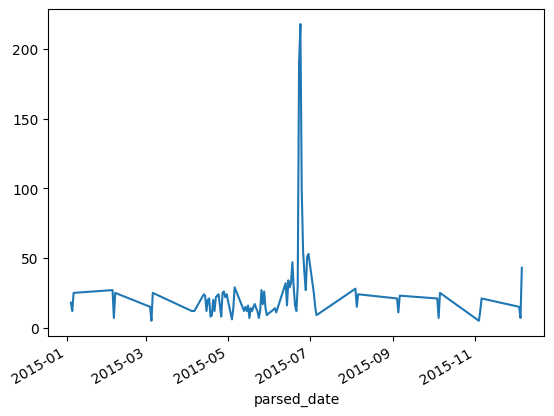

In [ ]:
# Daily trend
print(df['parsed_date'].value_counts().head(5))
df['parsed_date'].value_counts().plot()

 Jun 23rd and 24th received the highest number of complaints

In [ ]:
df['Year'] = pd.DatetimeIndex(df['parsed_date']).year
df['Month'] = pd.DatetimeIndex(df['parsed_date']).month
df['Month'] = df['Month'].apply(lambda x: calendar.month_abbr[x])



<Axes: ylabel='month_year'>

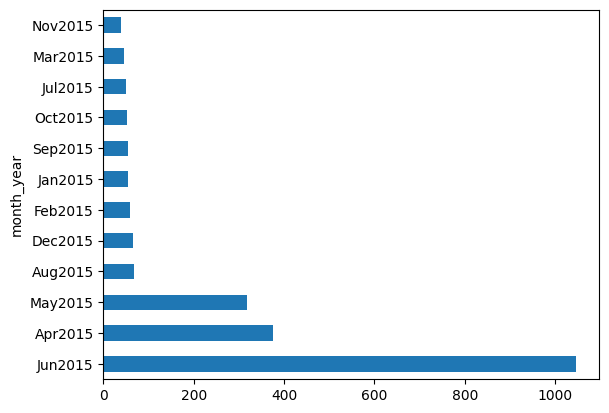

In [ ]:
df['month_year'] = df['Month'] + df['Year'].astype(str)

#Monthly trend
df['month_year'].value_counts().plot(kind="barh")


 The month of June received the maximum number of complaints

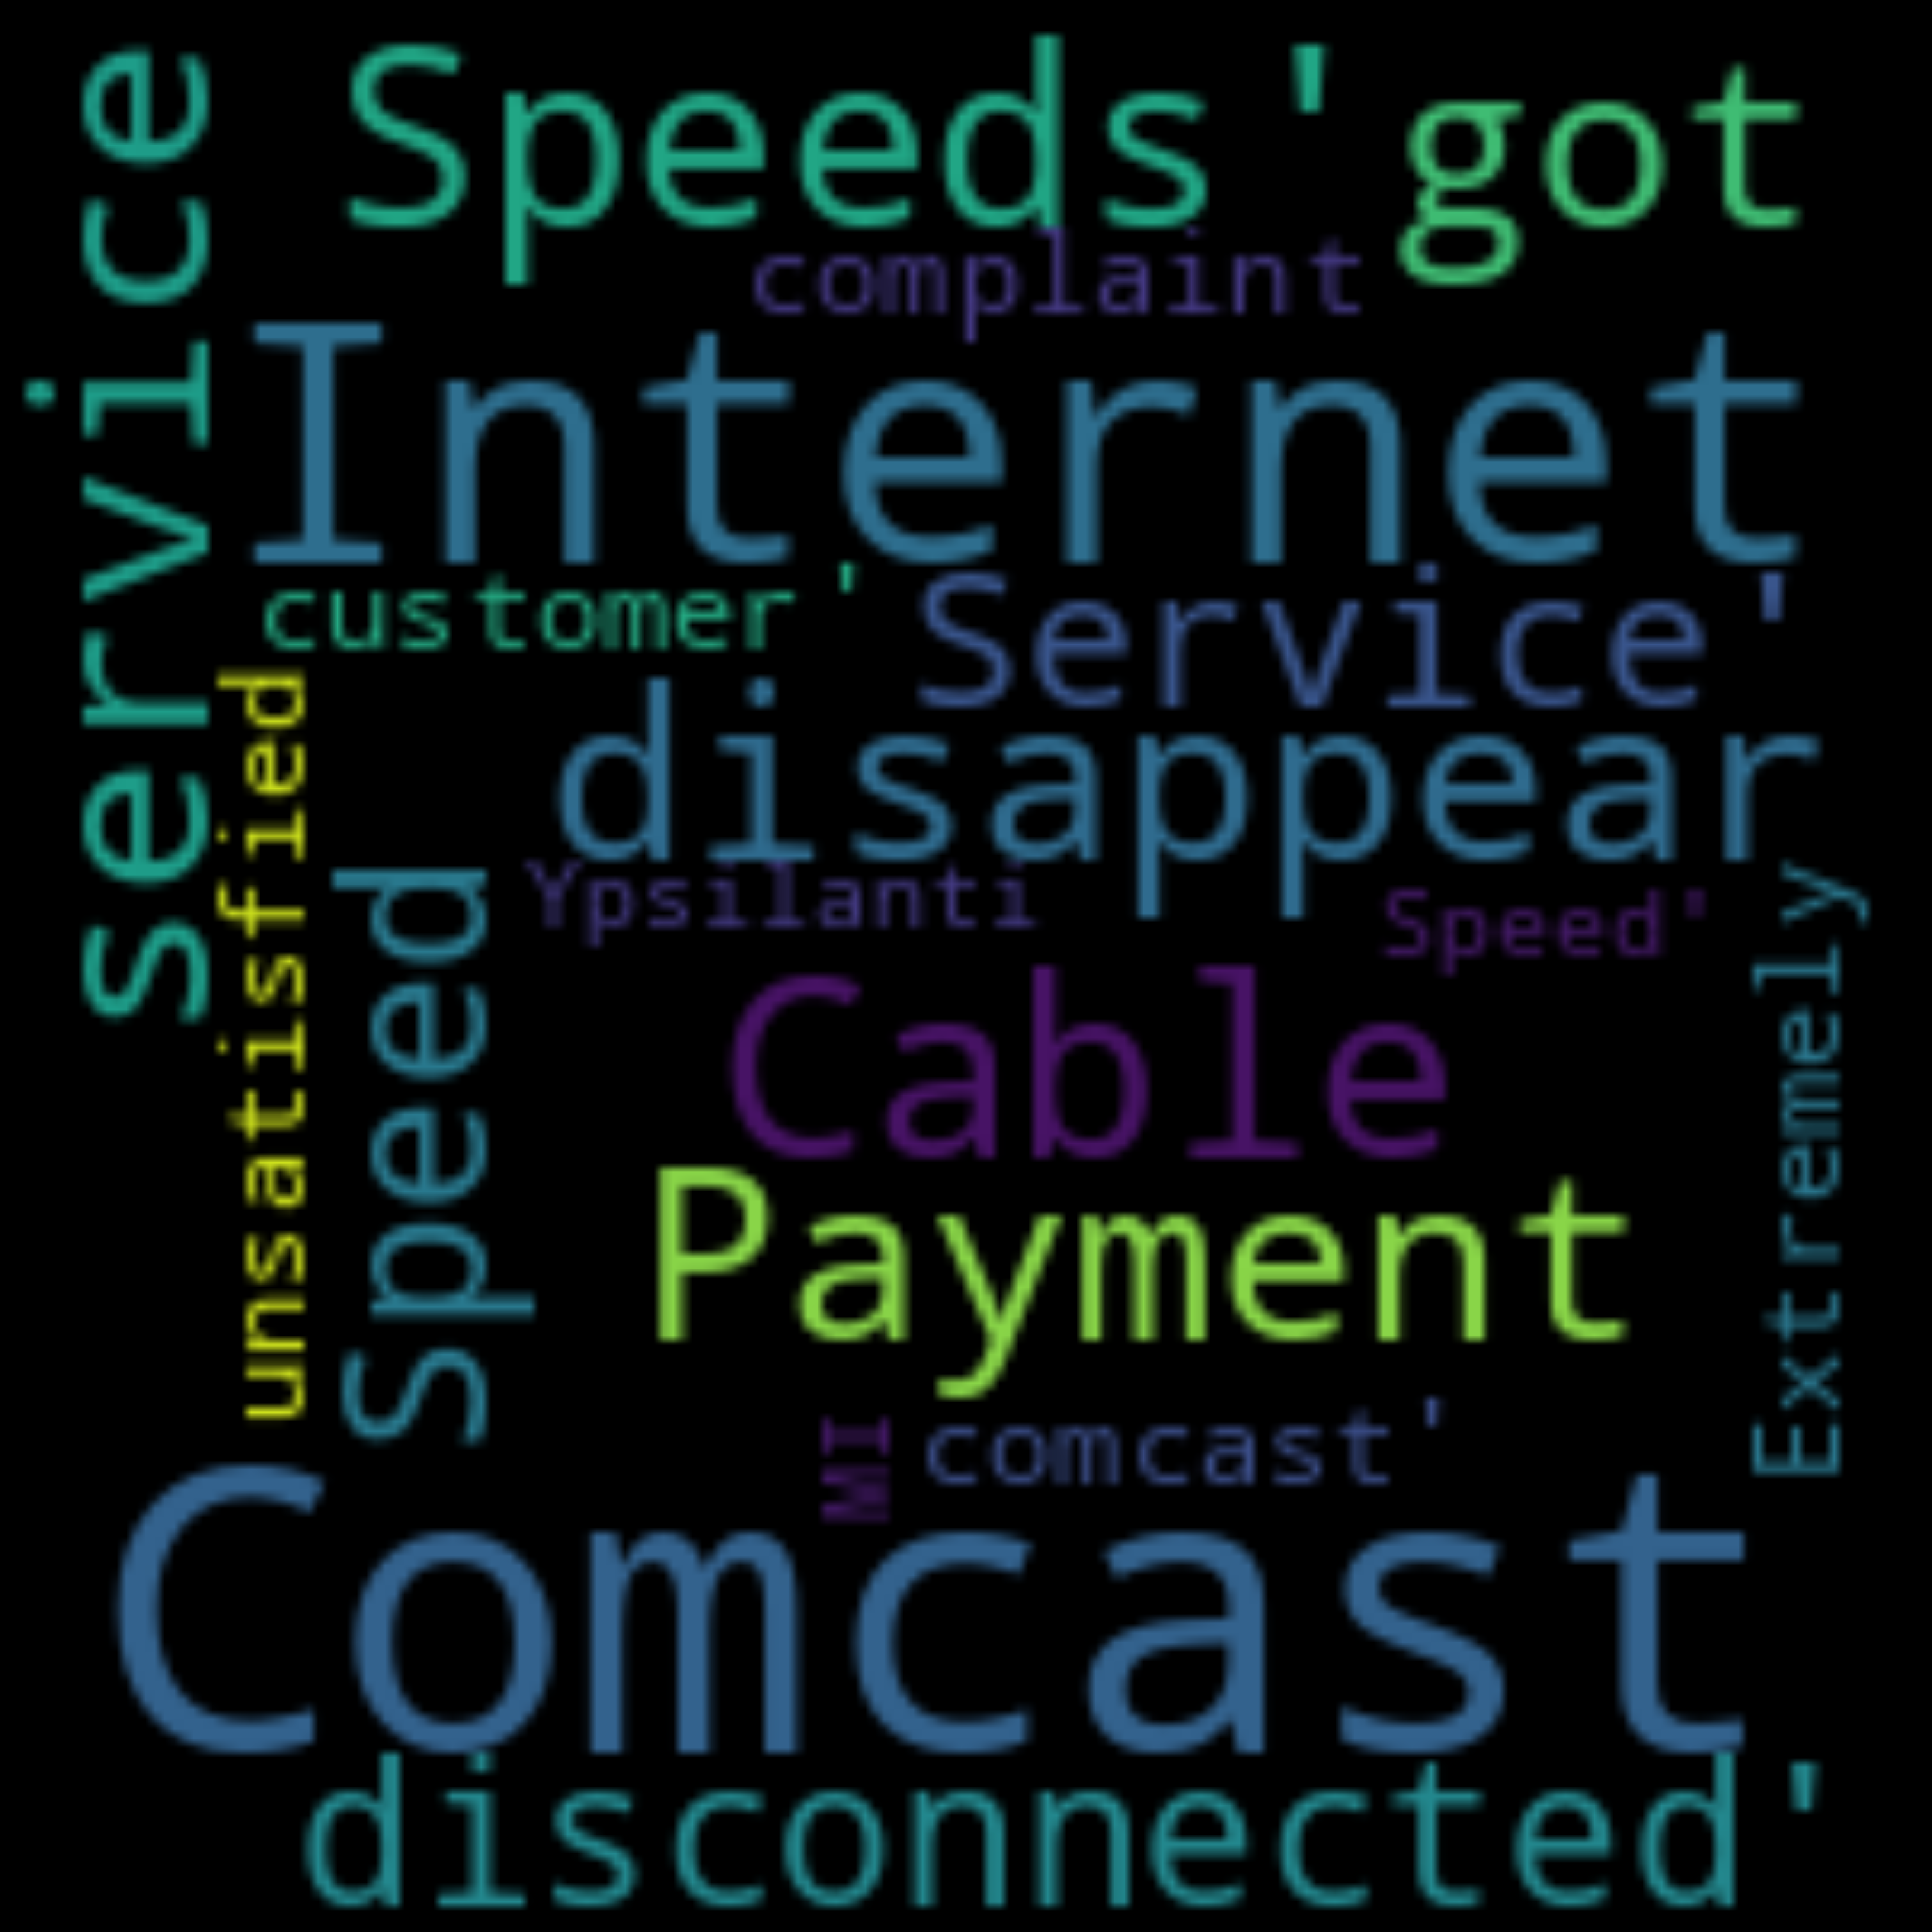

In [ ]:
# Unigram wordcloud for reviews
# note: this is a rough way to estimate most common complaints

from wordcloud import WordCloud, STOPWORDS

text = df['Customer Complaint'].values
wordcloud = WordCloud(width = 200, height = 200, background_color = 'black', stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()



By observing the above wordcloud, we can infer that most common complaints are around **Internet speed, service, and payment related issues.**

Let us verify the same using a ML model.

In [ ]:
!pip install pyLDAvis

In [ ]:
import re # We clean text using regex
from collections import defaultdict # For accumlating values
from nltk.corpus import stopwords # To remove stopwords
from gensim import corpora # To create corpus and dictionary for the LDA model
from gensim.models import LdaModel # To use the LDA model
import pyLDAvis.gensim # To visualise LDA model effectively
import pandas as pd
import nltk
import string
from nltk import pos_tag
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))


LookupError: ignored

In [ ]:
#load reviews
reviews = df["Customer Complaint"].tolist()

### Data Cleaning

In [ ]:
#remove all punctuations
reviews = [re.sub(r'[^\w\s]','',str(item)) for item in reviews]

# removing Stop-words
texts = [[word for word in document.lower().split() if word not in stopwords] for document in reviews]

#Taking out the less frequent words
frequency = defaultdict(int)
for text in texts:
    for token in text:
         frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]

In [ ]:
#Machine can’t understand words and documents as they are. So we split and vectorize them.
#Turning our text to a dictionary i.e. mapping between words and their integer ids.

#In this representation, each word is represented by one vector, where each vector element represents a question-answer pair.
#e.g. “How many times does the word 'Payment' appear in the coprus? Twice.”


dictionary = corpora.Dictionary(texts)
print(dictionary)

corpus = [dictionary.doc2bow(text) for text in texts]
corpus

#if corpus reads [(0,1),(1,4)] it means Word with ID no ‘0’ occurred one time and word with id number ‘1’ occurred 4 times.

**Topic modeling** is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents.
Latent Dirichlet Allocation (LDA) is an example of a model which is used to classify text in a document to a particular topic.
It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

In [ ]:
#LDA MODEL

NUM_TOPICS = 9 #  This is a Assumption. You can vary this
ldamodel = LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15) #This might take some time based on num_topics and passes.

In [ ]:
#Extracting Topics from the model

topics = ldamodel.show_topics()
for topic in topics:
    print(topic)



In [ ]:
#Above result looks too messy to understand easily. Let’s print them in a better view using pandas dataframe.

word_dict = {};
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 20)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

Observing the above words, we could make the below initial insights.
Tweaking number of passes and topics might yield better topics and results.

Note: Individual topic results will vary each time you run the model.

## Topic 1,5,7,8 – Comcast internet service is not reliable.  Internet speeds are not as promised.

## Topic 2,3,6,9 – Unfair billing practices

## Topic 4 – Data caps


In [ ]:
#Visualization using PyLDAvis

lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [ ]:
# Create a new categorical variable with value as - Open and Closed.
# Open & Pending to be categorized as 'Open' and Closed & Solved to be categorized as 'Closed'

df['Status'].unique()

In [ ]:
#creating another categorical variable
df.assign(Status2="")

In [ ]:
# Open & Pending to be categorized as 'Open' and Closed & Solved to be categorized as 'Closed'

df['Status2'] = ['Open' if (x == 'Open' or x =='Pending') else 'Closed' for x in df['Status']]


In [ ]:
Complaint_state_count = pd.core.frame.DataFrame({"count": df.groupby(['State']).size().sort_values(ascending=False)}).reset_index()
Complaint_state_count.head(10)

#Georgia has the highest number of complaints

In [ ]:
Status_complaint = df.groupby(['State', 'Status2']).size().unstack()
Status_complaint

In [ ]:
#State wise status of complaints in a stacked bar chart
df.groupby(['State', 'Status2']).size().unstack().plot(kind='barh',figsize=(20,20), stacked=True)



In [ ]:
Percentage_unresolved = [ Status_complaint['Open'] / (Status_complaint['Open']+Status_complaint['Closed'])]
Percentage_unresolved

# kansas has the highest nymber of unresolved cases

In [ ]:
df['Received Via'].unique()

#notice that there are only two categories

In [ ]:
np1 = df.groupby(['Status2']).size()
np1

In [ ]:
np2 = df.groupby(['Status2']).size().sum()
np2

In [ ]:
percentage_resolved = np1[0]/np2*100
percentage_resolved.round()

Resolution rate is **77%** for the complaints received through Internet and customer care calls.